In [2]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import os
import timm
import random
import matplotlib.ticker as ticker
import torch.nn.functional as F
import json
import torchvision
import cv2

from tqdm import tqdm, trange
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor
from pathlib import Path
from PIL import Image
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import optim
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights


In [3]:
class CarImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data['Filepath'].iloc[idx]
        image = Image.open(image_path)
        label = self.data['MSRP'].iloc[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

transform = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
])

In [68]:
#Define hyperparameters
batch_size = 16
lr = 5e-5
epochs = 10

In [69]:
train_label_set = pd.read_csv('train.csv')
valid_label_set = pd.read_csv('valid.csv')
train_label_set = train_label_set.head(1000)
valid_label_set = valid_label_set.head(100)

# Create the dataset
train_dataset = CarImageDataset(train_label_set, transform=transform)
valid_dataset = CarImageDataset(valid_label_set, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)


In [70]:
!pip install torchsummary
import torchsummary as summary

In [71]:
!pip install torchsummary

import torch
import timm
from torchsummary import summary

# Load the model
model = timm.create_model("resnet50", pretrained=True, num_classes = 1)
# Move the model to the desired device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Print the summary of the model
summary(model, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
         Identity-10           [-1, 64, 56, 56]               0
             ReLU-11           [-1, 64, 56, 56]               0
         Identity-12           [-1, 64, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [72]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def regression(model):
    num_epochs=epochs
    loss_func=nn.MSELoss()
    optimizer=optim.Adam(model.parameters(), lr = lr)
    train_dl=train_dataloader
    val_dl=valid_dataloader
    num_classes=1

    train_loss, val_loss, train_metric, val_metric =[], [], [], []
    best_loss = -1.0
    for epoch in tqdm(range(num_epochs)):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        #training
        model.train()
        loss, metric = regression_epoch(model, loss_func, train_dl, epoch,num_classes, optimizer)
        
#         mlflow.log_metric("train loss", loss, epoch)
#         for i in range(num_classes):
#             mlflow.log_metric(f"train metric {i}",metric[i], epoch)
        train_loss.append(loss)
        train_metric.append(metric)

        #validation
        model.eval()
        with torch.no_grad():
            loss, metric = regression_epoch(model, loss_func, val_dl, epoch, num_classes)
#         mlflow.log_metric("val loss", loss, epoch)

#         for i in range(num_classes):
#             mlflow.log_metric(f"val metric {i}",metric[i], epoch)
        val_loss.append(loss)
        val_metric.append(metric)
#         scheduler.step(val_loss[-1])

#         if epoch % log_epoch == log_epoch-1:
#             mlflow.pytorch.log_model(model, f'model_fold_{fold+1}_epoch_{epoch}', signature=signature)
            
         #saving best model
#         if sum(val_metric[-1])<best_loss or best_loss<0.0:
#             best_loss = sum(val_metric[-1])
#             mlflow.set_tag("best", f'best at epoch {epoch}')
#             mlflow.pytorch.log_model(model, f"best", signature=signature)
        print('The Validation Loss is {} and the validation accuracy is {}'.format(val_loss[-1],val_metric[-1]))
        print('The Training Loss is {} and the training accuracy is {}'.format(train_loss[-1],train_metric[-1]))

    return model, train_metric, val_metric, train_loss, val_loss


# calculate the loss per epochs
def regression_epoch(model, loss_func, dataset_dl, epoch, num_classes, opt=None):
    running_loss = 0.0
    running_metrics = np.zeros(num_classes)
    len_data = len(dataset_dl.sampler)
#     df = pd.DataFrame(columns=['file_name','predict1','predict2','regression1','regression2'])
    for xb, yb in tqdm(dataset_dl):
        xb = xb.to(device)
        yb = yb.to(device).float()
#         yb.unsqueeze(0)
        output = model(xb)
#         print(output)
#         print(yb)
        
        metric_b = np.zeros(num_classes)
        total_loss = 0.0
#         for i in range(num_classes):
        loss_b = loss_func(output, yb)
        total_loss += loss_b
        metric_b += loss_b.item()

        if opt is not None:
            opt.zero_grad()
            total_loss.backward()
            opt.step()
            
            # validation값 저장하는 부분
#             output = list(output.detach().cpu().numpy())
#             yb = list(yb.cpu().numpy())
#             name_b = list(name_b)
#             for i in range(len(output)):
#                 data = {'file_name':name_b[i],
#                         'predict1':output[i][0], 
#                         'predict2':output[i][1],
#                         'regression1':yb[i][0],
#                         'regression2':yb[i][1],
#                        }
#                 new_row = pd.DataFrame(data=data, index=['file_name'])
#                 df = pd.concat([df,new_row], ignore_index=True)

#             if not os.path.exists('temp'):
#                 os.mkdir('temp')
#             df.to_csv('temp/last_data.csv')
#             mlflow.log_artifact('temp/last_data.csv', f'output_epoch_{epoch}')

        running_loss += total_loss.item()
        if metric_b is not None:
            running_metrics += metric_b

#         if sanity_check is True:
#             break

    loss = running_loss / len_data
    metric = running_metrics / len_data
    return loss, metric

In [73]:
#####학습
model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=1)
regression(model)

  0%|                                                                                                             | 0/63 [00:00<?, ?it/s]/Users/jeesuppark/opt/miniconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)

 84%|████████████████████████████████████████████████████████████████████████████████████▏               | 53/63 [02:49<00:30,  3.09s/it]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▍ | 62/63 [03:17<00:03,  3.13s/it]/Users/jeesuppark/opt/miniconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [03:18<00:00,  3.16s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████▍              | 6/7 [00:07<00:01,  1.18s/it]/Users/jeesuppark/opt/miniconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead 

The Validation Loss is 40.81898590087891 and the validation accuracy is [40.8189859]
The Training Loss is 133.30952026367189 and the training accuracy is [133.30952026]



 90%|██████████████████████████████████████████████████████████████████████████████████████████▍         | 57/63 [02:55<00:18,  3.04s/it]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [03:13<00:00,  3.07s/it]

 20%|████████████████████                                                                                | 2/10 [06:47<27:05, 203.19s/it]

The Validation Loss is 44.56269622802734 and the validation accuracy is [44.56269623]
The Training Loss is 126.74721011352538 and the training accuracy is [126.74721011]



 90%|██████████████████████████████████████████████████████████████████████████████████████████▍         | 57/63 [03:04<00:18,  3.15s/it]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [03:21<00:00,  3.20s/it]

 30%|██████████████████████████████                                                                      | 3/10 [10:16<24:01, 205.92s/it]

The Validation Loss is 48.73343170166016 and the validation accuracy is [48.7334317]
The Training Loss is 127.1001947479248 and the training accuracy is [127.10019475]



 90%|██████████████████████████████████████████████████████████████████████████████████████████▍         | 57/63 [03:02<00:18,  3.07s/it]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [03:20<00:00,  3.18s/it]

 40%|████████████████████████████████████████                                                            | 4/10 [13:44<20:39, 206.60s/it]

The Validation Loss is 44.98552917480469 and the validation accuracy is [44.98552917]
The Training Loss is 127.6247876586914 and the training accuracy is [127.62478766]



 90%|██████████████████████████████████████████████████████████████████████████████████████████▍         | 57/63 [03:05<00:18,  3.10s/it]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [03:23<00:00,  3.23s/it]

 50%|██████████████████████████████████████████████████                                                  | 5/10 [17:14<17:20, 208.11s/it]

The Validation Loss is 46.100819702148435 and the validation accuracy is [46.1008197]
The Training Loss is 125.69541937255859 and the training accuracy is [125.69541937]



 90%|██████████████████████████████████████████████████████████████████████████████████████████▍         | 57/63 [02:57<00:18,  3.08s/it]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [03:14<00:00,  3.08s/it]

 60%|████████████████████████████████████████████████████████████                                        | 6/10 [20:36<13:43, 205.83s/it]

The Validation Loss is 52.54652099609375 and the validation accuracy is [52.546521]
The Training Loss is 125.52854916381835 and the training accuracy is [125.52854916]



 90%|██████████████████████████████████████████████████████████████████████████████████████████▍         | 57/63 [02:55<00:18,  3.05s/it]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [03:11<00:00,  3.05s/it]

 70%|██████████████████████████████████████████████████████████████████████                              | 7/10 [23:55<10:10, 203.65s/it]

The Validation Loss is 45.551351623535155 and the validation accuracy is [45.55135162]
The Training Loss is 127.01164056396485 and the training accuracy is [127.01164056]



 90%|██████████████████████████████████████████████████████████████████████████████████████████▍         | 57/63 [02:59<00:21,  3.61s/it]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [03:16<00:00,  3.13s/it]

 80%|████████████████████████████████████████████████████████████████████████████████                    | 8/10 [27:19<06:47, 203.89s/it]

The Validation Loss is 51.64557067871094 and the validation accuracy is [51.64557068]
The Training Loss is 125.38859942626954 and the training accuracy is [125.38859943]



 90%|██████████████████████████████████████████████████████████████████████████████████████████▍         | 57/63 [02:56<00:18,  3.04s/it]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [03:13<00:00,  3.07s/it]

 90%|██████████████████████████████████████████████████████████████████████████████████████████          | 9/10 [30:40<03:22, 202.81s/it]

The Validation Loss is 47.577458190917966 and the validation accuracy is [47.57745819]
The Training Loss is 128.47684985351563 and the training accuracy is [128.47684985]



 90%|██████████████████████████████████████████████████████████████████████████████████████████▍         | 57/63 [02:55<00:18,  3.03s/it]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [03:12<00:00,  3.06s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [34:00<00:00, 204.02s/it]

The Validation Loss is 48.63108489990234 and the validation accuracy is [48.6310849]
The Training Loss is 126.22055200195312 and the training accuracy is [126.220552]


(VisionTransformer(
   (patch_embed): PatchEmbed(
     (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
     (norm): Identity()
   )
   (pos_drop): Dropout(p=0.0, inplace=False)
   (blocks): Sequential(
     (0): Block(
       (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
       (attn): Attention(
         (qkv): Linear(in_features=768, out_features=2304, bias=True)
         (attn_drop): Dropout(p=0.0, inplace=False)
         (proj): Linear(in_features=768, out_features=768, bias=True)
         (proj_drop): Dropout(p=0.0, inplace=False)
       )
       (ls1): Identity()
       (drop_path1): Identity()
       (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
       (mlp): Mlp(
         (fc1): Linear(in_features=768, out_features=3072, bias=True)
         (act): GELU(approximate='none')
         (drop1): Dropout(p=0.0, inplace=False)
         (fc2): Linear(in_features=3072, out_features=768, bias=True)
         (drop2): Dropout(p=0.0, inplace=Fa

In [128]:
class VITAttentionRollout:
    def __init__(self, model, attention_layer_name='attn_drop', head_fusion="mean", discard_ratio=0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
        for name, module in self.model.named_modules():
            if attention_layer_name in name:
                module.register_forward_hook(self.get_attention)

        self.attentions = []

    def get_attention(self, module, input, output):
        self.attentions.append(output.cpu())

    def __call__(self, input_tensor):
        self.attentions = []
        with torch.no_grad():
            output = self.model(input_tensor)

        return rollout(self.attentions, self.discard_ratio, self.head_fusion)
    
def rollout(attentions, discard_ratio, head_fusion):
    result = torch.eye(attentions[0].size(-1))
    with torch.no_grad():
        for attention in attentions:
            if head_fusion == "mean":
                attention_heads_fused = attention.mean(axis=1)
            elif head_fusion == "max":
                attention_heads_fused = attention.max(axis=1)[0]
            elif head_fusion == "min":
                attention_heads_fused = attention.min(axis=1)[0]
            else:
                raise "Attention head fusion type Not supported"

            # Drop the lowest attentions, but
            # don't drop the class token
            flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
            _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
            indices = indices[indices != 0]
            flat[0, indices] = 0

            I = torch.eye(attention_heads_fused.size(-1))
            a = (attention_heads_fused + 1.0*I)/2
            a = a / a.sum(dim=-1)

            result = torch.matmul(a, result)
    
    # Look at the total attention between the class token,
    # and the image patches
    mask = result[0, 0 , 1 :]
    # In case of 224x224 image, this brings us from 196 to 14
    width = int(mask.size(-1)**0.5)
    mask = mask.reshape(width, width).numpy()
    mask = mask / np.max(mask)
    return mask

def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

In [129]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image

index = 64

img1 = Image.open(train_label_set['Filepath'][index])

img1 = img1.resize((224, 224))
input_tensor1 = transform(img1).unsqueeze(0)

attention_rollout = VITAttentionRollout(model, head_fusion="mean", discard_ratio=0.5)
mask1 = attention_rollout(input_tensor1)

np_img1 = np.array(img1)[:,:,::-1]
mask1 = cv2.resize(mask1, (np_img1.shape[1], np_img1.shape[0]))
mask1 = show_mask_on_image(np_img1, mask1)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(mask1)
axs[0].set_title('Masked Image')
axs[1].imshow(img1)
axs[1].set_title('Original Image')

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()


IndexError: too many indices for tensor of dimension 2

In [ ]:
[133.30952026367189,
  126.74721011352538,
  127.1001947479248,
  127.6247876586914,
  125.69541937255859,
  125.52854916381835,
  127.01164056396485,
  125.38859942626954,
  128.47684985351563,
  126.22055200195312],
 [40.81898590087891,
  44.56269622802734,
  48.73343170166016,
  44.98552917480469,
  46.100819702148435,
  52.54652099609375,
  45.551351623535155,
  51.64557067871094,
  47.577458190917966,
  48.63108489990234])

In [130]:
for name, module in model.named_modules():
    print(name)
# print(model.named_modules)


patch_embed
patch_embed.proj
patch_embed.norm
pos_drop
blocks
blocks.0
blocks.0.norm1
blocks.0.attn
blocks.0.attn.qkv
blocks.0.attn.attn_drop
blocks.0.attn.proj
blocks.0.attn.proj_drop
blocks.0.ls1
blocks.0.drop_path1
blocks.0.norm2
blocks.0.mlp
blocks.0.mlp.fc1
blocks.0.mlp.act
blocks.0.mlp.drop1
blocks.0.mlp.fc2
blocks.0.mlp.drop2
blocks.0.ls2
blocks.0.drop_path2
blocks.1
blocks.1.norm1
blocks.1.attn
blocks.1.attn.qkv
blocks.1.attn.attn_drop
blocks.1.attn.proj
blocks.1.attn.proj_drop
blocks.1.ls1
blocks.1.drop_path1
blocks.1.norm2
blocks.1.mlp
blocks.1.mlp.fc1
blocks.1.mlp.act
blocks.1.mlp.drop1
blocks.1.mlp.fc2
blocks.1.mlp.drop2
blocks.1.ls2
blocks.1.drop_path2
blocks.2
blocks.2.norm1
blocks.2.attn
blocks.2.attn.qkv
blocks.2.attn.attn_drop
blocks.2.attn.proj
blocks.2.attn.proj_drop
blocks.2.ls1
blocks.2.drop_path1
blocks.2.norm2
blocks.2.mlp
blocks.2.mlp.fc1
blocks.2.mlp.act
blocks.2.mlp.drop1
blocks.2.mlp.fc2
blocks.2.mlp.drop2
blocks.2.ls2
blocks.2.drop_path2
blocks.3
blocks.3.n

In [114]:
model = timm.create_model("resnet50", pretrained=True, num_classes=1)
print(model.named_modules)

<bound method Module.named_modules of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine

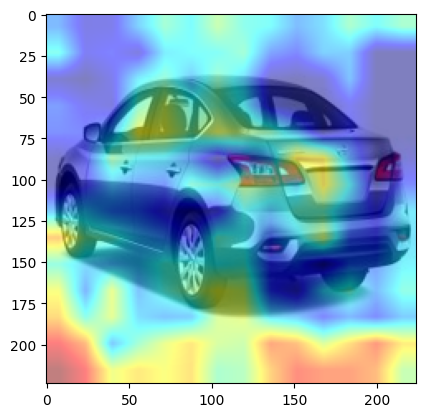

In [177]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

model = timm.create_model("resnet50", pretrained=True, num_classes=1)
target_layers = [model.layer3[-1]]

img1 = Image.open(train_label_set['Filepath'][221])
img1 = img1.resize((224, 224))
input_tensor1 = transform(img1).unsqueeze(0)

cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)

targets = [ClassifierOutputTarget(0)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
# Normalize the image to the range [0, 1]
img1_normalized = np.float32(img1) / 255.0

visualization = show_cam_on_image(img1_normalized, grayscale_cam, use_rgb=True)
plt.imshow(visualization)

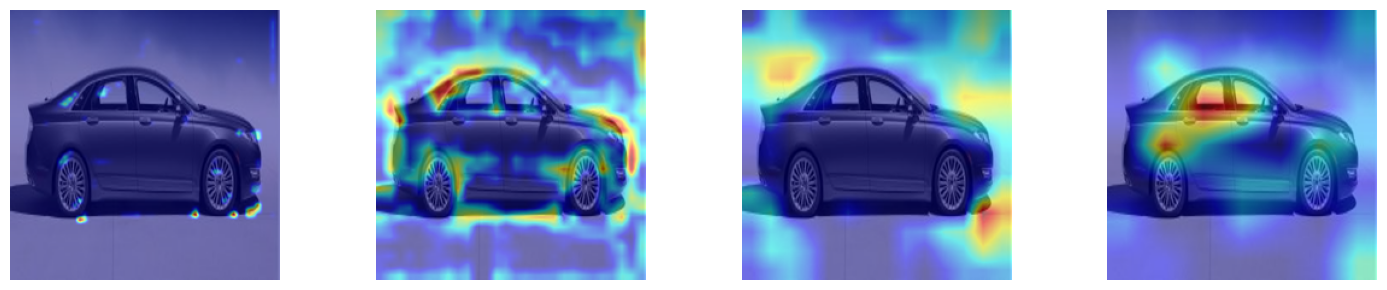

In [198]:
import matplotlib.pyplot as plt

model = timm.create_model("resnet50", pretrained=True, num_classes=1)
target_layers = [model.layer1[-1], model.layer2[-1], model.layer3[-1], model.layer4[-1]]

# Load and preprocess the image
img = Image.open(train_label_set['Filepath'][66])
img = img.resize((224, 224))
input_tensor = transform(img).unsqueeze(0)

# Create GradCAM instances for each target layer
cams = [GradCAM(model=model, target_layers=[layer], use_cuda=False) for layer in target_layers]

# Specify the class target
targets = [ClassifierOutputTarget(0)]

# Compute the gradients and visualizations for each layer
visualizations = []
for cam in cams:
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    img_normalized = np.float32(img) / 255.0
    visualization = show_cam_on_image(img_normalized, grayscale_cam, use_rgb=True)
    visualizations.append(visualization)

# Create subplots for each layer visualization
num_layers = len(visualizations)
fig, axs = plt.subplots(1, num_layers, figsize=(15, 3))

# Display each layer visualization in a separate subplot
for i in range(num_layers):
    axs[i].imshow(visualizations[i])
    axs[i].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()
